# Housing data prediction

In [2]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

%matplotlib inline

## 1. Data Import and exploration

In [3]:
kc_data_all = pd.read_csv('kc_house_data.csv')
kc_data_all.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
print('available data columns: ', kc_data_all.columns)
print('data size: ', kc_data_all.shape)
print('data types: ', kc_data_all.dtypes)

available data columns:  Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
data size:  (21613, 21)
data types:  id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


First lets see if there are any null values in the data which need to addressed. After that, lets take the numeric columns and view the distributions for each of them to see what values they have and what kind of distributions they follow. Followed by the categorical columns to see how they are distributed and their values

### 1.1 Look for null or invalid values

In [5]:
for col in kc_data_all.columns[2:]:
    print('number of null values in column ', col, ': ', kc_data_all[kc_data_all[col].isnull() | \
                                                                     (kc_data_all[col] < 0)].size)

number of null values in column  price :  0
number of null values in column  bedrooms :  0
number of null values in column  bathrooms :  0
number of null values in column  sqft_living :  0
number of null values in column  sqft_lot :  0
number of null values in column  floors :  0
number of null values in column  waterfront :  0
number of null values in column  view :  0
number of null values in column  condition :  0
number of null values in column  grade :  0
number of null values in column  sqft_above :  0
number of null values in column  sqft_basement :  0
number of null values in column  yr_built :  0
number of null values in column  yr_renovated :  0
number of null values in column  zipcode :  0
number of null values in column  lat :  0
number of null values in column  long :  453873
number of null values in column  sqft_living15 :  0
number of null values in column  sqft_lot15 :  0


ok great test 1 passed really well, no null values

### 1.2 Data Distribution Viz

In [9]:
numeric_features = ['price', 'sqft_living',\
                    'sqft_lot', 'sqft_above',\
                    'sqft_basement']
categorical_features = ['condition',\
                        'bedrooms', 'floors',\
                        'grade', \
                        'waterfront', 'view', 'condition']

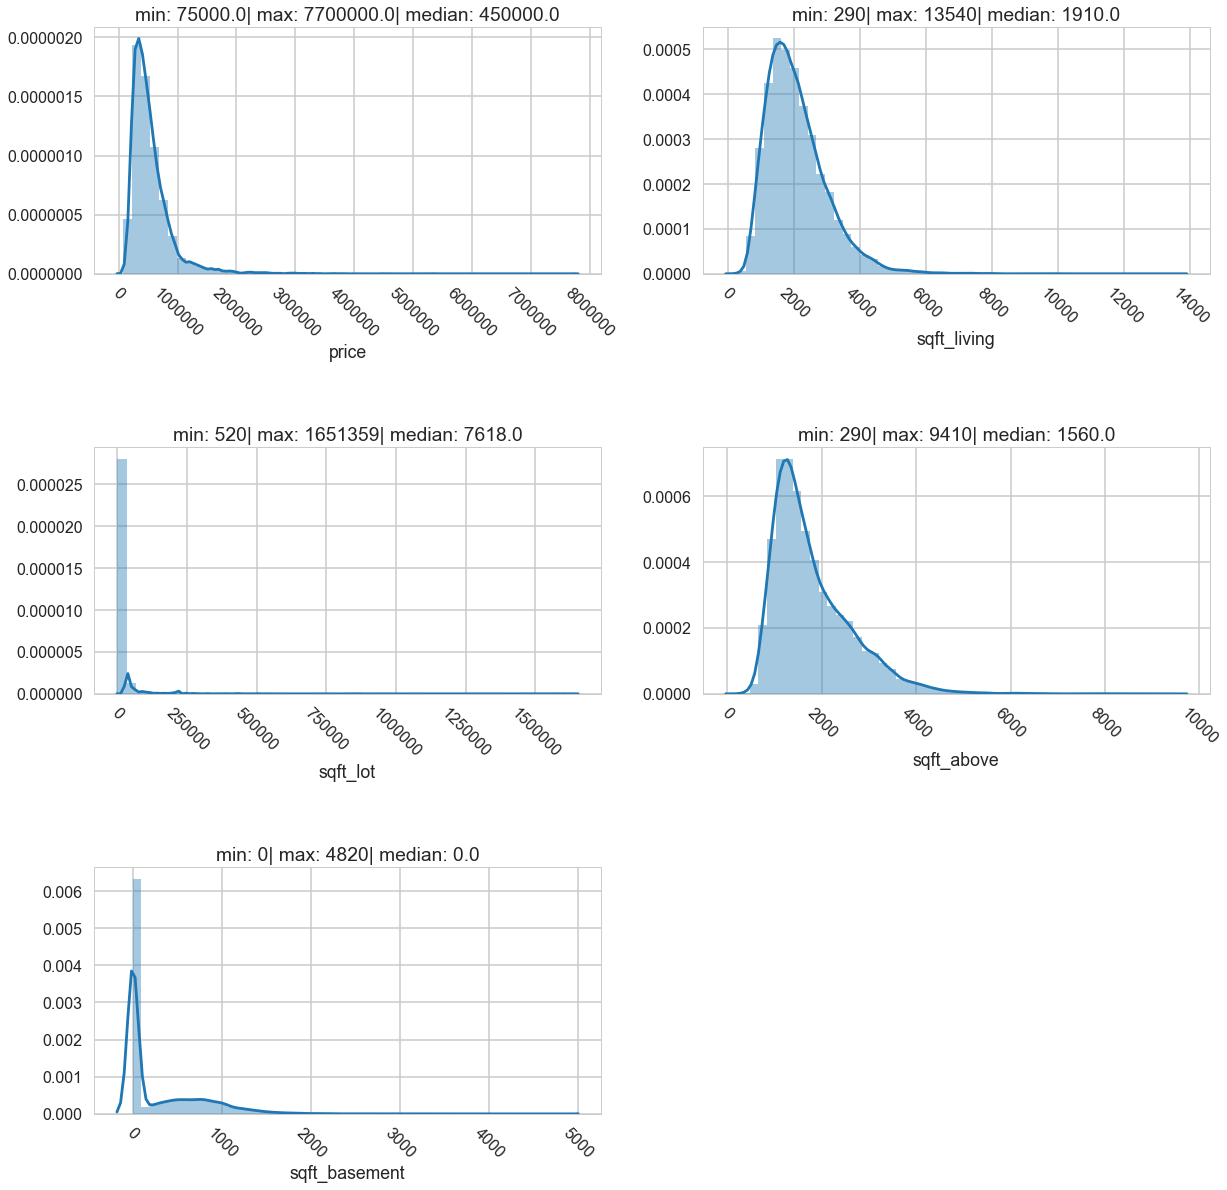

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
fig.subplots_adjust(hspace=.7)
fig.delaxes(axs[-1,-1])
for i in range(len(numeric_features)):
    sns.distplot(kc_data_all[numeric_features[i]], ax=axs[i//2,i%2])
    plt.setp(axs[i//2,i%2].get_xticklabels(), rotation=-45)
    axs[i//2,i%2].set_title('min: ' + \
                            str(kc_data_all[numeric_features[i]].min()) +\
                            '| max: ' +\
                            str(kc_data_all[numeric_features[i]].max()) +\
                           '| median: ' +\
                            str(kc_data_all[numeric_features[i]].median()))
plt.draw()

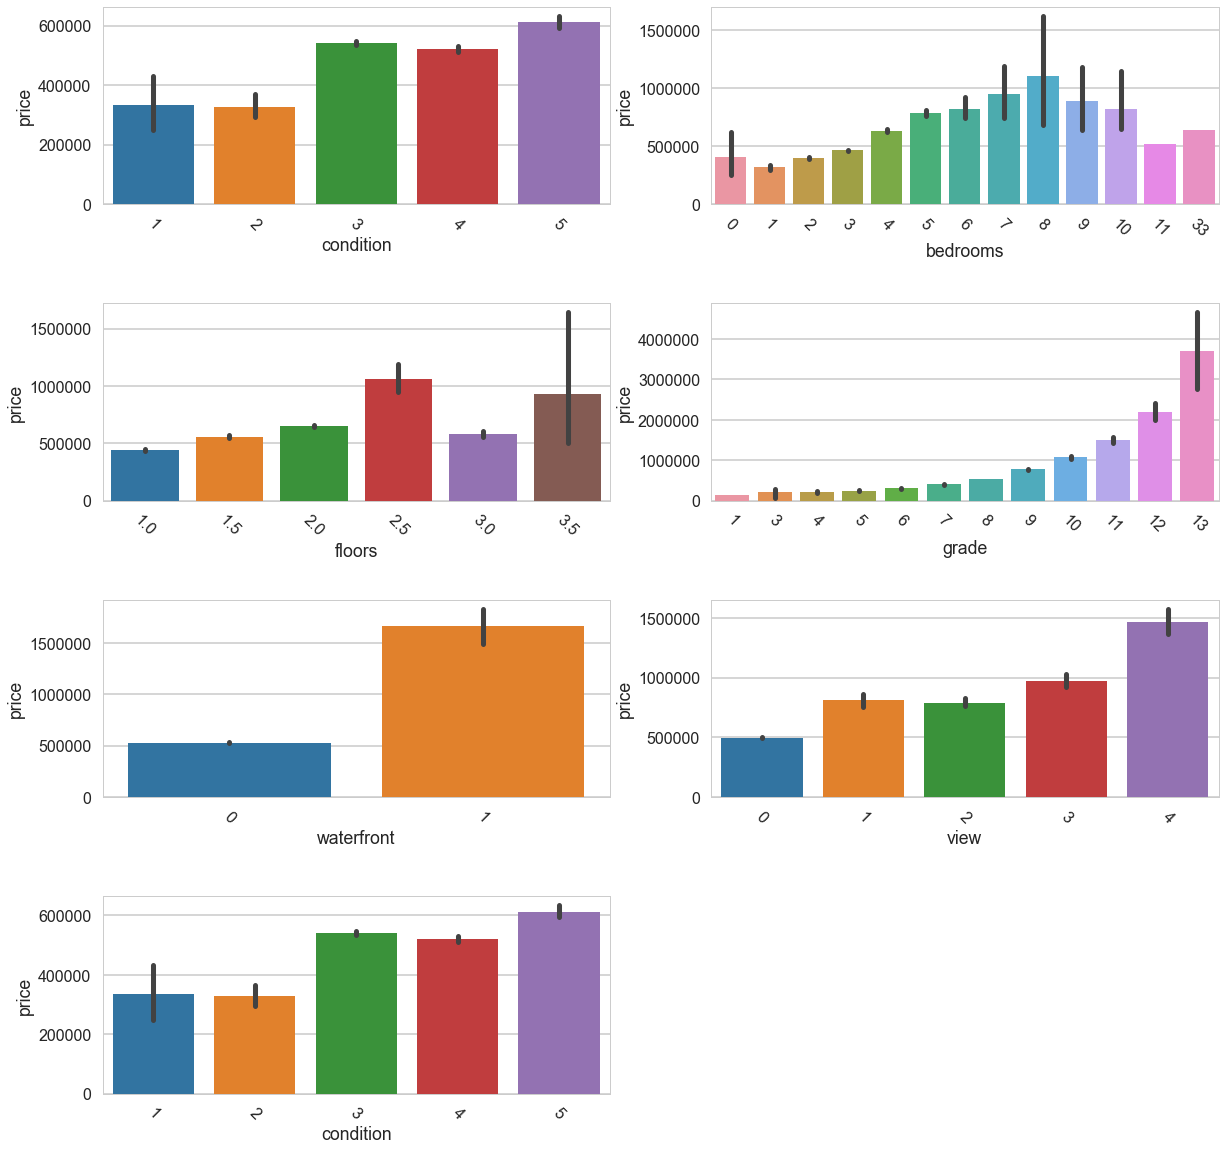

In [8]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20,20))
fig.subplots_adjust(hspace=.5)
fig.delaxes(axs[-1,-1])
for i in range(len(categorical_features)):
    sns.barplot(data=kc_data_all, x=categorical_features[i], y='price', ax=axs[i//2,i%2])
    plt.setp(axs[i//2,i%2].get_xticklabels(), rotation=-45)

### 1.3 Correlations
Looking at correlations between the target and features as is

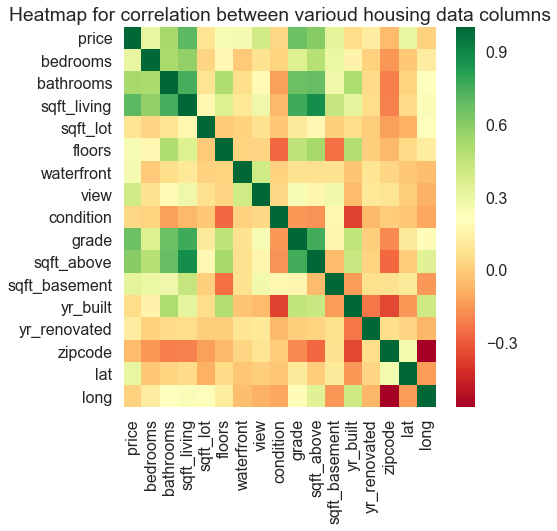

In [59]:
kc_data_corr = kc_data_all.drop(['id', 'sqft_living15', 'sqft_lot15'], axis=1).corr()

plt.figure(figsize=(7,7))
sns.heatmap(kc_data_corr, cmap='RdYlGn')
plt.title('Heatmap for correlation between varioud housing data columns')

### 1.4 Baseline model based on the most correlated feature(s)

First things first let's split our data into test and train sets

In [49]:
# performing an 80-20 split
from sklearn.model_selection import train_test_split

kc_data_train, kc_data_test = train_test_split(kc_data_all, test_size=0.2, random_state = 1)
print(kc_data_all.size)
print(kc_data_train.size)
print(kc_data_test.size)

# setting up a target column so that we can easily use the going forward
#feature lists will be created in their own model blocks
target = ['price']

453873
363090
90783


Train RMSE:  253091.78
Train MAPE:  35.8 %
Test RMSE:  292797.84
Test MAPE:  35.88 %


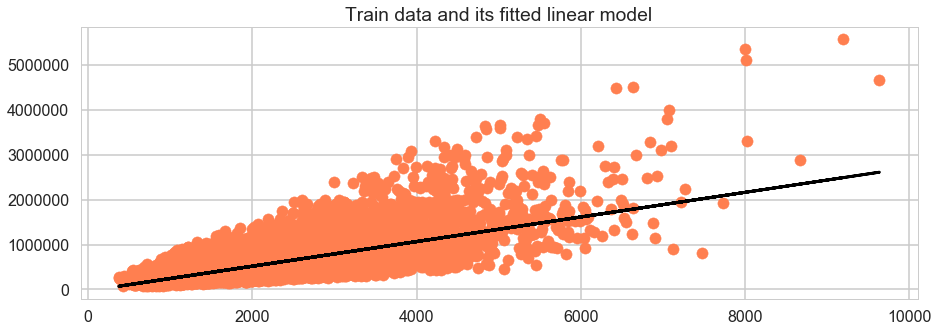

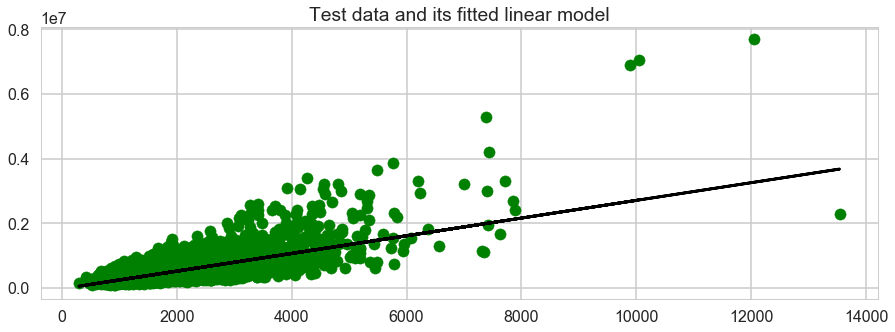

In [109]:
from sklearn import linear_model
from sklearn import metrics

slm_features = ['sqft_living']

# simple linear regression using sqft model
slm = linear_model.LinearRegression()

X_train = kc_data_train[slm_features]
y_train = kc_data_train[target]

X_test = kc_data_test[slm_features]
y_test = kc_data_test[target]

slm_sqft_model = slm.fit(X=X_train, y=y_train)
y_hat_train = slm.predict(X_train)
y_hat_test = slm.predict(X_test)

print ('Train RMSE: ', round(np.sqrt(((y_train - y_hat_train)**2).mean()), 2))
print ('Train MAPE: ', round(((abs(y_train - y_hat_train))/y_train).mean()*100, 2), '%')

print ('Test RMSE: ', round(np.sqrt(((y_test - y_hat_test)**2).mean()), 2))
print ('Test MAPE: ', round(((abs(y_test - y_hat_test))/y_test).mean()*100, 2), '%')

plt.figure(figsize=(15,5))
plt.scatter(X_train, y_train,color='coral')
plt.plot(X_train, y_hat_train,color='k')
plt.title('Train data and its fitted linear model')

plt.figure(figsize=(15,5))
plt.scatter(X_test, y_test,color='g')
plt.plot(X_test, slm_sqft_model.predict(X_test),color='k')
plt.title('Test data and its fitted linear model')

We can ofcourse do better

### 1.5 Observations and proposed improvements to features

ok so what have we learnt so far:
1. the data seems pretty clean, it does not have any null values and it has (at least while eyeballing) sensible values
2. There are quite a few columns which can be transformed, like the year built, year renovated, zip code
3. Not quite sure what to do with lat long at this point, perhaps its not quite as useful
4. as expected, sqft_living, # of brs baths, view and grade are highly positively correlated. So are sqft_above and sqft_basement but sqft_basement is concentrated around the 0 value so can be transformed too. 
5. A lot of the columns mentioned above including sqft living, bath, br, sqft_above, grade and others are correlated to each other. Something to watch out for to avoid overfitting
6. There is a date column avaialable too, will want to see what date ranges are available, could look into a time series model for price increase in the kc area as a next step

what to do next:
1. Since there is not much data cleaning to do, lets start with transforming the columns above to see how they perform and if they should be used. We should also normalize some of the columns like sqft in order to ensure they don't adversely effect the model
2. visualize the correlations and price values for each
3. look at scatter plots for price vs some of the numeric variables to see the relationships and if they are linear or not
4. Aply a baseline linear regression model
5. apply a regression model with variying degrees as well as perhaps some interation variables like perhaps bedrooms and bathrooms
6. once we make the model more complex apply regularization 
7. perform cross validation and by it tune the hyperparameters of the regularization algorithms

## 2. Feature Engineering

Going Feature by Feature

### 2.1 bedrooms
Looks like 

> bathrooms

> sqft_living

> sqft_lot

> floors

> waterfront

> view

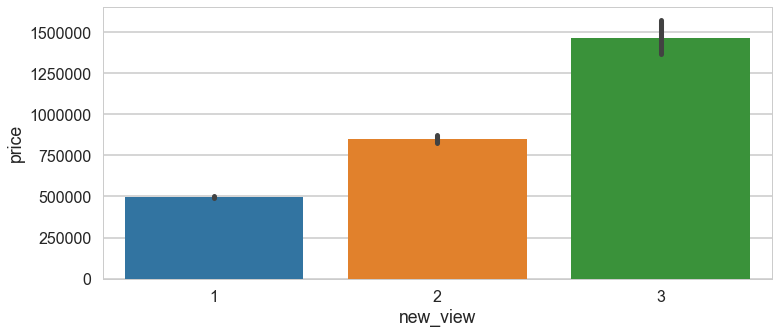

In [100]:
kc_data_all.loc[(kc_data_all.view == 0), 'new_view'] = 1
kc_data_all.loc[(kc_data_all.view > 0) & (kc_data_all.view < 4), 'new_view'] = 2
kc_data_all.loc[(kc_data_all.view == 4), 'new_view'] = 3
fig = plt.figure(figsize=(12,5))
sns.barplot(data=kc_data_all, x='new_view', y='price')

In [110]:
# Apply one-hot encoding for the new_view variable
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
new_view_encoded = enc.fit_transform(np.reshape(np.array(kc_data_all.new_view), (-1,1))).toarray()
for i in range(len(new_view_encoded[0])):
    kc_data_all['view_'+str(i)] = new_view_encoded[:, i]
kc_data_all.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,house_age,is_renovated,new_view,is_highpriced_neighborhood,view_0,view_1,view_2
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,-122.346,1530,1509,9,0.0,1,0,1.0,0.0,0.0
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,-122.362,1830,7200,4,0.0,1,0,1.0,0.0,0.0
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,-122.299,1020,2007,9,0.0,1,0,1.0,0.0,0.0
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,-122.069,1410,1287,14,0.0,1,0,1.0,0.0,0.0
21612,1523300157,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,-122.299,1020,1357,10,0.0,1,0,1.0,0.0,0.0


> condition

> grade

> sqft_above

> sqft_basement

> yr_built

In [17]:
# transforming year build to the age of the house
kc_data_all['house_age'] = pd.datetime.now().year - kc_data_all.yr_built

> yr_renovated

In [19]:
kc_data_all.loc[kc_data_all.yr_renovated == 0, 'is_renovated'] = 0
kc_data_all.loc[kc_data_all.yr_renovated != 0, 'is_renovated'] = 1

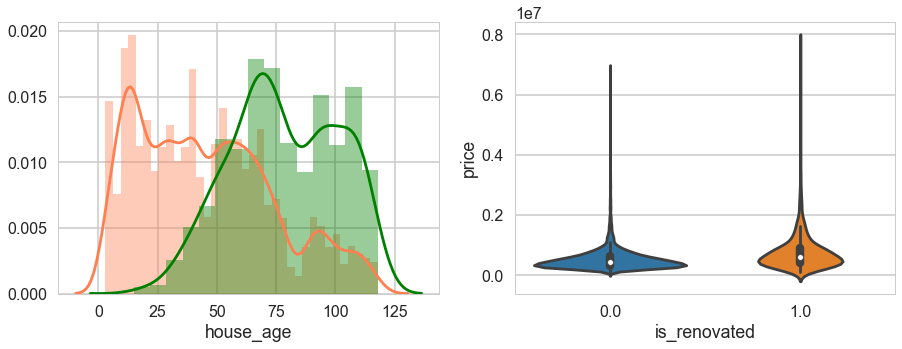

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.distplot(kc_data_all[kc_data_all.is_renovated == 0].house_age, ax=axs[0], label='not renovated', color='coral')
sns.distplot(kc_data_all[kc_data_all.is_renovated == 1].house_age, ax=axs[0], label='is renovated', color='green')
sns.violinplot(data=kc_data_all, x='is_renovated', y='price', ax=axs[1])

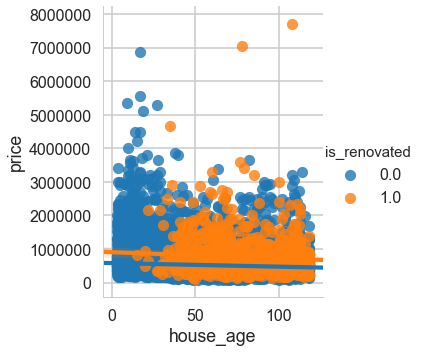

In [52]:
sns.lmplot(data=kc_data_all, x='house_age', y='price', hue='is_renovated')

> zipcode

In [55]:
kc_data_all.zipcode.unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69]), <a list of 70 Text xticklabel objects>)

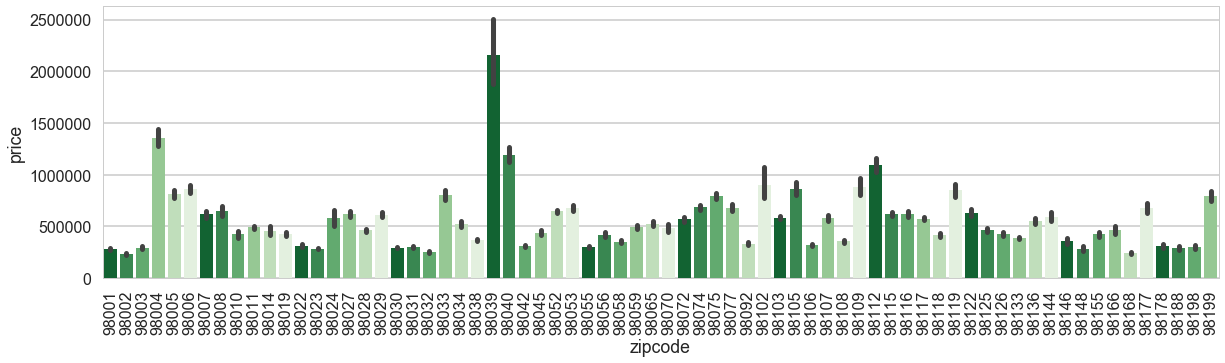

In [65]:
fig = plt.figure(figsize=(20,5))
sns.barplot(data=kc_data_all, x='zipcode', y='price', palette=sns.color_palette("Greens_r"))
plt.xticks(rotation=90)

ok so looks like the zipcode 98039 really stand out with really high home prices. It makes sense since that is the zipcode for the neighborhood of Medina WA where the 2 richest men in the world live, Bill Gates and Jeff Bezos <br>
<img src='Medina.png', style="width:500px;">

### Open Question: So how do I handle this??
perhaps I can create an indicator variable for high priced zipcodes like 98039. However, what should be threshold to include neighborhoods in this indicator, would 98040 (Bellevue) and 98004 (Mercer Island) be included?

In [74]:
#creating indicator variable for Medina
kc_data_all['is_highpriced_neighborhood'] = 0
kc_data_all.loc[kc_data_all.zipcode==98039, 'is_highpriced_neighborhood'] = 1

> lat

> long

> sqft_living15
> sqft_lot15


ok so looks like brand new homes which are not renovated do have higher prices and older homes which are renovated tend to have higher prices. Although overall the house age does not matter

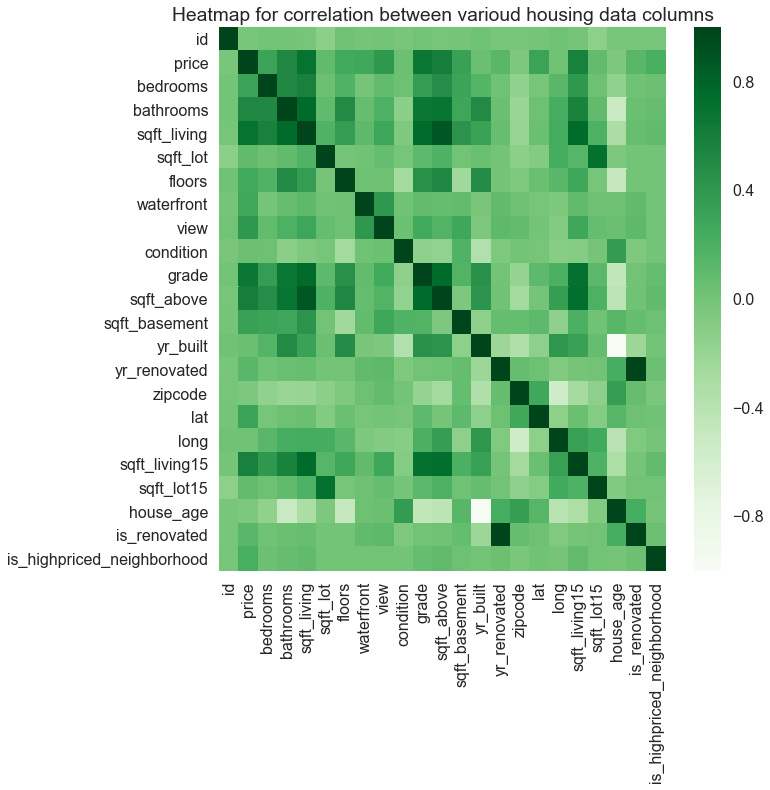

In [75]:
kc_data_corr = kc_data_all.corr()

plt.figure(figsize=(10,10))
sns.heatmap(kc_data_corr, cmap='Greens')
plt.title('Heatmap for correlation between varioud housing data columns')

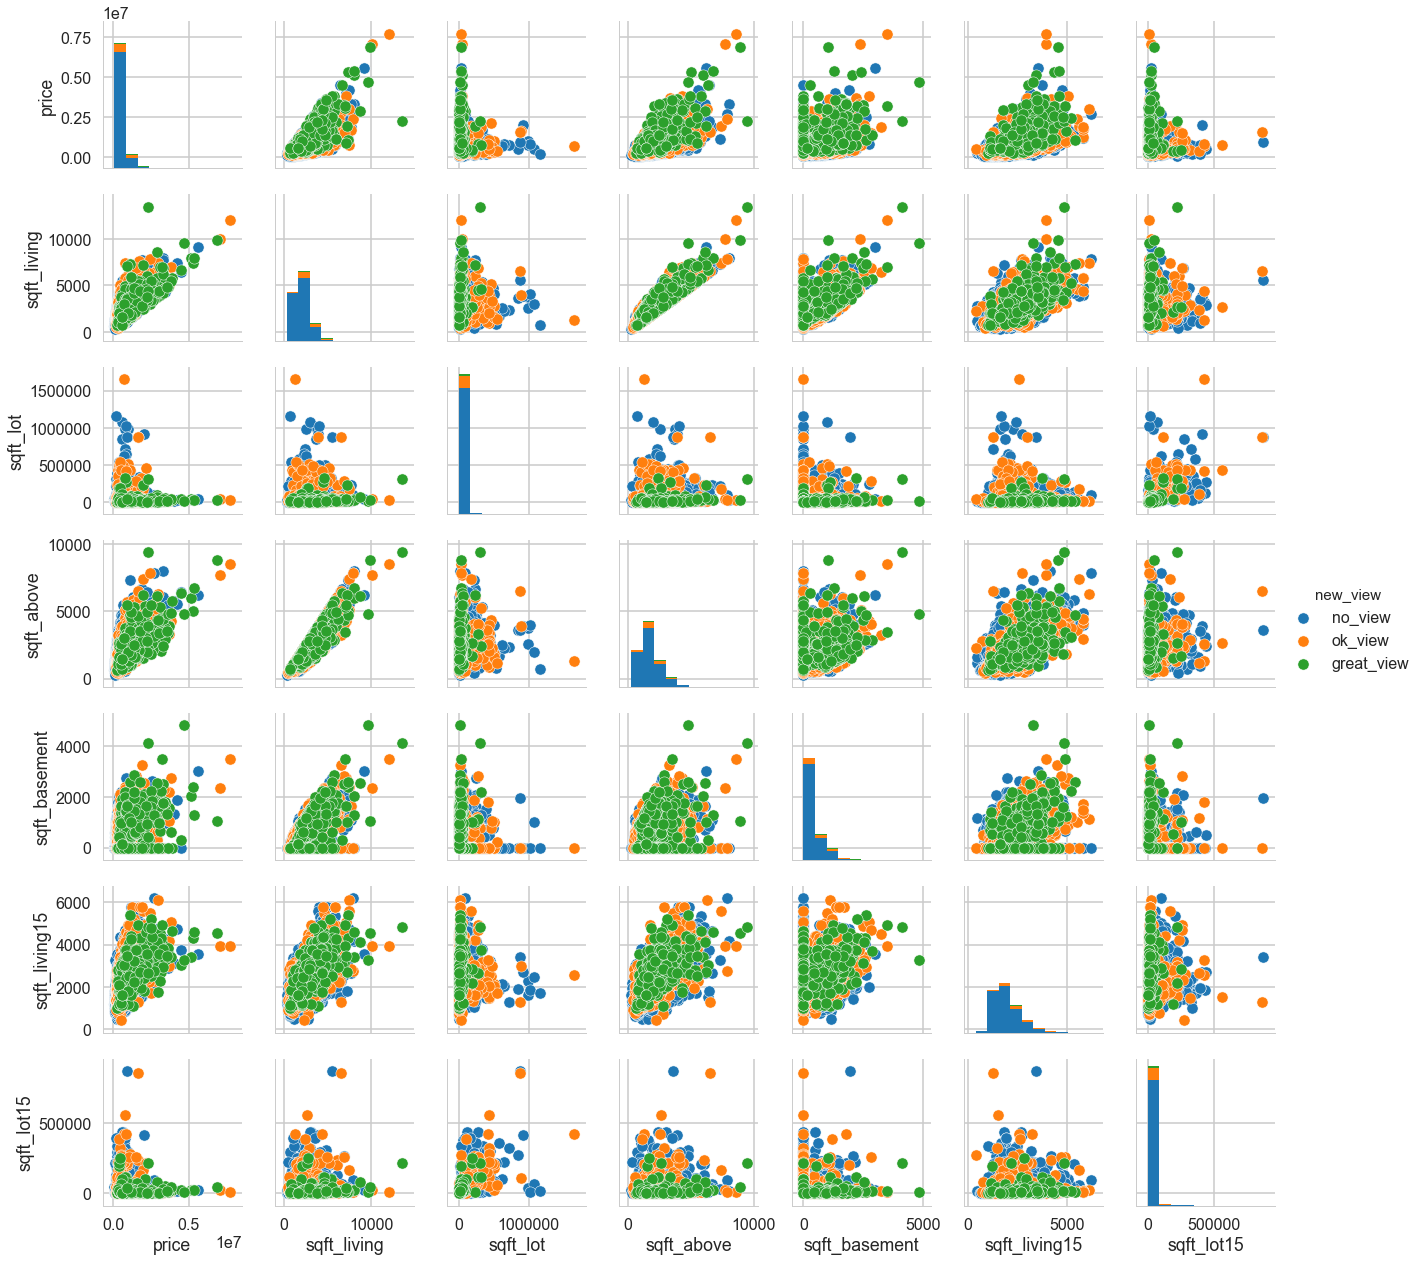

In [72]:
sns.pairplot(kc_data_all[numeric_features + ['new_view']], hue='new_view')

## 3. Model Selection & Training